In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [67]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [68]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
engine.execute(text('SELECT * FROM measurement')).keys()

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])

In [27]:
engine.execute(text('SELECT * FROM station')).keys()

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])

In [28]:
# Find the most recent date in the data set.
session.query(measurement.date).\
    order_by(measurement.date.desc()).first()

('2017-08-23',)

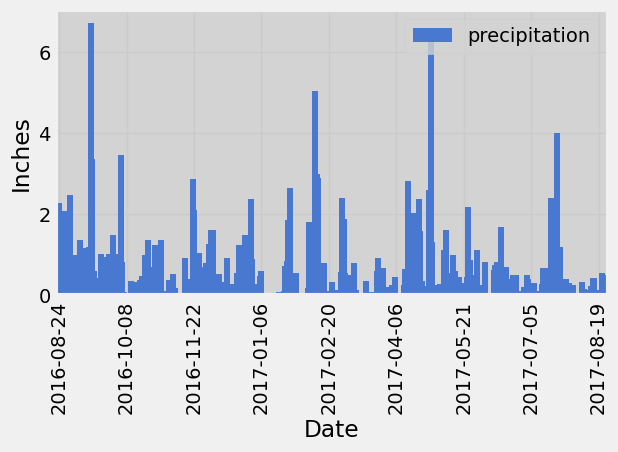

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()
    
# Calculate the date one year from the last date in data set.
last = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date,func.max(measurement.prcp)).\
                  filter(measurement.date > last).\
                  group_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = pd.DataFrame(query, columns=['date','prcp'])

# Sort the dataframe by date
data.sort_values('date', inplace=True)

# Set the date column as the index
data.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

# Plot the precipitation data
ax = data.plot.bar(width=4)  # Adjust the width parameter to change the bar size

# Adjust x-axis tick positions and labels
x_ticks = ax.get_xticks()
x_ticks_interval = len(x_ticks) // 8  
ax.set_xticks(x_ticks[::x_ticks_interval])
ax.set_xticklabels(data.index[::x_ticks_interval], rotation=90)

plt.xlabel('Date')
plt.ylabel('Inches')

# Change the legend label
ax.legend(['precipitation'])

plt.tight_layout()
plt.show()

In [58]:
# Use Pandas to calculate the summary statistics for the precipitation data
data.dropna(inplace=True)
data.describe()

,prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [65]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).count()


9

In [75]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

query


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    measurement.station,
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs),
]

query = session.query(*sel).\
    filter(measurement.station=='USC00519281').all()
    
query   

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

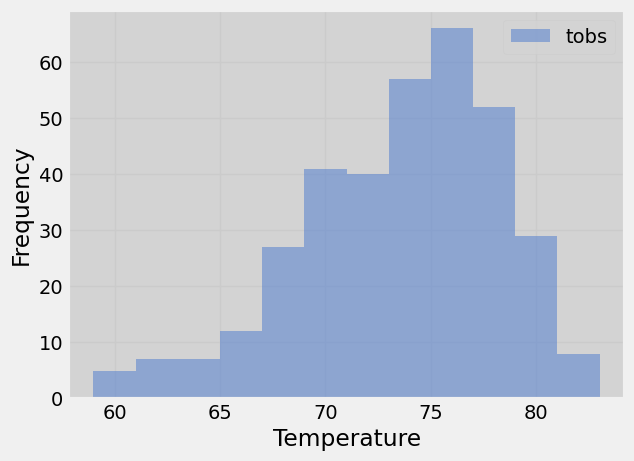

In [82]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.date,measurement.tobs).\
                  filter(measurement.date > last).\
                  filter(measurement.station=='USC00519281').all()
                  
data = pd.DataFrame(query)

data.set_index('date',inplace=True)

plt.hist(data['tobs'],bins=12,alpha=0.5)

plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.legend(['tobs'])

plt.show()


# Close Session

In [83]:
# Close Session
session.close()